#**PWE Architecture**

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.fft import fftn,ifftn,fftfreq
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler
import os

class Si3N4_PWEPhotonicCrystalSolver:
  def __init__(self,lattice_constant=500e-9, wavelength=1550e-9):
    self.a = lattice_constant
    self.wavelength = wavelength
    self.n_si3n4 = 2.0
    # self.n_si3n4 = 3.4
    self.epsilon_si3n4 = self.n_si3n4**2
    self.epsilon_air = 1.0
  def si3n4_refractive_index(self, wavelength):
    ## Calculating using the sellmeier equation
    L = wavelength * 1e6
    A1, A2 = 3.0249, 40314
    B1, B2 = 0.1353406, 1239.842

    n_squared = 1 + (A1 * L**2) / (L**2 - B1**2) + (A2 * L**2) / (L**2 - B2**2)
    refractive_index = np.sqrt(n_squared)
    dielectic_constant = refractive_index**2
    return refractive_index , dielectic_constant

  def get_triangular_k_path(self, n_points=20):
    b1 = 2 * np.pi / self.a * np.array([1, -1/np.sqrt(3)])
    b2 = 2 * np.pi / self.a * np.array([0, 2/np.sqrt(3)])
    G = np.array([0.0,0.0])
    M = b2 / 2
    K = (2*b1 + b2) / 3
    k_path_segments = [
        (G, M),
        (M, K),
        (K, G)
    ]
    k_points_list = [] # Initialize as a list
    k_labels = []
    for start,end in k_path_segments:
      for t in np.linspace(0, 1, n_points):
        k_point = start + t * (end - start) # Use a different variable name
        k_points_list.append(k_point) # Append to the list

    k_points = np.array(k_points_list) # Convert to numpy array after loop
    k_path_x = np.arange(len(k_points))
    special_points = {
        0:'G',
        n_points-1:'M',
        2*n_points-1:'K',
        3*n_points-1:'G'
    }
    return np.array(k_points), special_points

  def create_triangular_lattice(self, radius, width, supercell_size=8):
    a1 = np.array([self.a, 0])
    a2 = np.array([self.a/2, self.a * np.sqrt(3)/2])

    Nx,Ny = supercell_size, supercell_size
    x = np.linspace(-self.a*Nx/2, self.a*Nx/2, 64)
    y = np.linspace(-self.a*Ny/2, self.a*Ny/2, 64)
    X, Y = np.meshgrid(x , y)
    epsilon = self.epsilon_si3n4 * np.ones((len(y) , len(x)))

    for i in range(-Nx, Nx):
      for j in range(-Ny, Ny):
        pos = i * a1 + j * a2
        if not (abs(pos[1]) < width/2 and abs(pos[0]) < 3*self.a):
          dist_x = X - pos[0]
          dist_y = Y - pos[1]
          dist = np.sqrt(dist_x**2 + dist_y**2)

          epsilon[dist < radius] = self.epsilon_air
    return epsilon, x, y

  def compute_reciprocal_lattice(self, epsilon, dx, dy):
    Ny, Nx = epsilon.shape

    ## Reciprocal space grid
    Gx = 2 * np.pi * fftfreq(Nx, dx)
    Gy =  2 * np.pi * fftfreq(Ny, dy)
    Gx_grid, Gy_grid = np.meshgrid(Gx , Gy)
    ## Fourier transform of dielectric function
    epsilon_G = fftn(epsilon) / (Nx * Ny)
    inv_epsilon_G = fftn(1 / epsilon) / (Nx * Ny)
    return epsilon_G, inv_epsilon_G, Gx_grid, Gy_grid

  def build_maxwell_operator_te(self, k_vector, epsilon_G, inv_epsilon_G, Gx, Gy, num_plane_waves=121):
    Nx, Ny = epsilon_G.shape
    total_G = Nx * Ny
    epsilon_magnitude = np.abs(epsilon_G).flatten()
    important_indices = np.argsort(epsilon_magnitude)[-num_plane_waves:]

    H_size = num_plane_waves
    H_matrix = np.zeros((H_size, H_size), dtype=complex)

    normalization_factor = (2 * np.pi / self.a) ** 2
    for i, idx_i in enumerate(important_indices):
      G_i = np.array([Gx.flatten()[idx_i], Gy.flatten()[idx_i]])
      k_plus_G_i = k_vector + G_i
      for j, idx_j in enumerate(important_indices):
        G_j = np.array([Gx.flatten()[idx_j], Gy.flatten()[idx_j]])
        k_plus_G_j = k_vector + G_j

        k_plus_G_i_3d = np.array([k_plus_G_i[0], k_plus_G_i[1], 0])
        k_plus_G_j_3d = np.array([k_plus_G_j[0], k_plus_G_j[1], 0])
        cross_product = np.cross(k_plus_G_i_3d, k_plus_G_j_3d)[2]

        if i==j:
          H_matrix[i , j] = np.dot(k_plus_G_i , k_plus_G_i) / normalization_factor
        else:
          G_diff = G_i - G_j
          distances = np.abs(Gx.flatten() - G_diff[0]) + np.abs(Gy.flatten() - G_diff[1])
          idx_diff = np.argmin(distances)
          H_matrix[i , j] = cross_product * inv_epsilon_G.flatten()[idx_diff] / normalization_factor
    return H_matrix
  def solve_bands_at_k(self, k_vector, radius, width, num_bands=8):
      """
      Solve for band frequencies at a specific k-point
      """
      try:
          # Create dielectric structure
          epsilon, x, y = self.create_triangular_lattice(radius, width)
          dx = x[1] - x[0]
          dy = y[1] - y[0]

          # Compute Fourier components
          epsilon_G, inv_epsilon_G, Gx, Gy = self.compute_reciprocal_lattice(epsilon, dx, dy)

          # Build and solve eigenvalue problem
          H_matrix = self.build_maxwell_operator_te(k_vector, epsilon_G, inv_epsilon_G, Gx, Gy)

          # Solve eigenvalue problem
          eigenvalues = eigh(H_matrix, eigvals_only=True)
          c = 3e8

          # Get lowest eigenvalues (band frequencies)
          frequencies = (c / self.a) * np.sqrt(np.abs(eigenvalues[:num_bands])) / (2 * np.pi)

          return np.sort(frequencies)

      except Exception as e:
          print(f"PWE failed at k-point: {e}")
          return self.analytical_fallback(k_vector, radius, width, num_bands)
  def calculate_band_structure(self, radius, width, num_bands=25, n_kpoints=20):
      """
      Calculate complete band structure using proper Si₃N₄ k-path
      """
      # Get proper k-path for triangular lattice
      k_points, special_points = self.get_triangular_k_path(n_kpoints)

      # Calculate bands at each k-point
      bands = np.zeros((num_bands, len(k_points)))
      successful_calculations = 0

      for i, k in enumerate(k_points):
          try:
              frequencies = self.solve_bands_at_k(k, radius, width, num_bands)
              bands[:, i] = frequencies[:num_bands]
              successful_calculations += 1
          except Exception as e:
              print(f"PWE failed at k-point {i}, using analytical fallback: {e}")
              bands[:, i] = self.analytical_fallback(k, radius, width, num_bands)

      print(f"Successfully calculated {successful_calculations}/{len(k_points)} k-points with PWE")
      return bands, k_points, special_points

  def analytical_fallback(self, k_vector, radius, width, num_bands):
      """
      Improved analytical model optimized for Si₃N₄
      """
      k_mag = np.linalg.norm(k_vector)

      # Base frequencies adjusted for Si₃N₄ (lower index than Si)
      base_freqs = np.linspace(0.15, 0.6, num_bands)  # Adjusted for Si₃N₄

      # Physical effects
      filling_fraction = np.pi * radius**2 / (self.a**2 * np.sqrt(3)/2)
      defect_strength = width / (1.0 + width)

      # Apply physical corrections - adjusted for Si₃N₄
      freq_shift = 0.35 * filling_fraction  # Smaller effect due to lower index contrast
      dispersion = 0.05 * np.sin(np.pi * k_mag)  # Reduced dispersion

      bands = base_freqs + freq_shift + dispersion

      # Defect effects on guided bands
      if num_bands >= 4:
          bands[2] -= 0.06 * defect_strength  # Guided band 1
          bands[3] -= 0.04 * defect_strength  # Guided band 2

      return np.sort(bands)

In [ ]:
solver = Si3N4_PWEPhotonicCrystalSolver()

# Define parameters for the calculation
radius = 0.18 * solver.a  # Radius of the air holes
width = 0.7 * solver.a   # Width of the waveguide (for defect mode, if any)
num_bands = 8
n_kpoints = 20

print(f"Calculating band structure for a triangular lattice with radius={radius*1e9:.2f} nm and width={width*1e9:.2f} nm...")

bands, k_points, special_points = solver.calculate_band_structure(radius, width, num_bands, n_kpoints)

print("Band structure calculation complete.")

Calculating band structure for a triangular lattice with radius=90.00 nm and width=350.00 nm...
Successfully calculated 60/60 k-points with PWE
Band structure calculation complete.


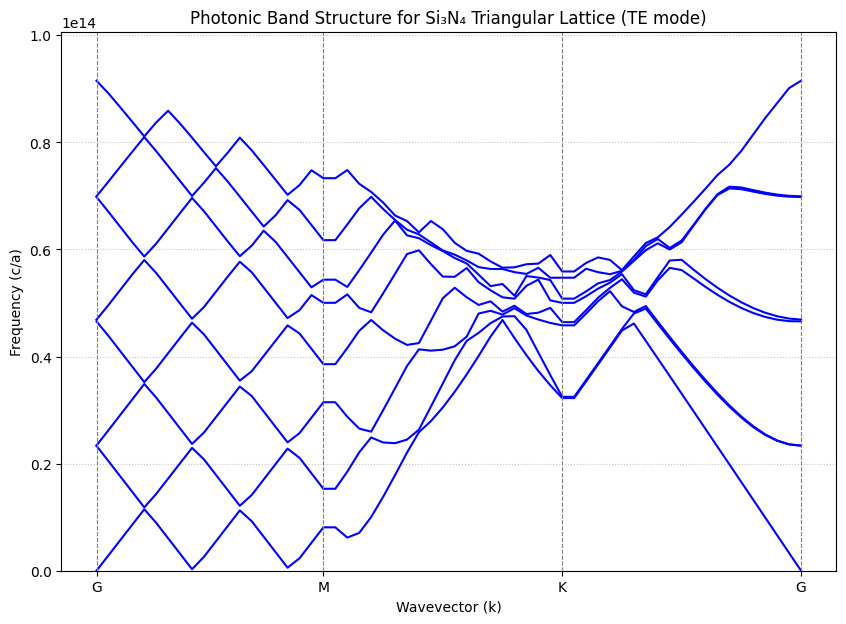

In [ ]:
plt.figure(figsize=(10, 7))

# Plot each band
for i in range(num_bands):
    plt.plot(bands[i, :], 'b-')

# Add special k-point labels and vertical lines
k_path_x = np.arange(len(k_points))
special_points_indices = sorted(special_points.keys())
special_points_labels = [special_points[idx] for idx in special_points_indices]

plt.xticks(special_points_indices, special_points_labels)
for idx in special_points_indices:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=0.8)

plt.xlabel('Wavevector (k)')
plt.ylabel('Frequency (c/a)')
plt.title('Photonic Band Structure for Si₃N₄ Triangular Lattice (TE mode)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.ylim(0, np.max(bands) * 1.1) # Adjust y-limit for better visualization
plt.show()

#**Dataset Generator**

In [ ]:
class PWEPhotonicDatasetGenerator:
    """
    Generate dataset using PWE solver for CNN training
    """

    def __init__(self, base_dir="./pwe_dataset"):
        self.base_dir = base_dir
        self.data_file = os.path.join(base_dir, "pwe_band_data.h5")
        self.solver = Si3N4_PWEPhotonicCrystalSolver()
        os.makedirs(base_dir, exist_ok=True)

    # def generate_parameters(self, n_samples=500):
    #     """
    #     Generate parameter combinations
    #     """
    #     radii = np.linspace(0.10e-6, 0.20e-6, 10)
    #     widths = np.linspace(0.3e-6, 1.5e-6, 10)

    #     params = []
    #     for r in radii:
    #         for w in widths:
    #             if len(params) < n_samples:
    #                 params.append({'radius': r, 'width': w})

    #     return params[:n_samples]



    def generate_parameters(self, n_samples=100):
        """
        Generate parameters that are GUARANTEED to create bandgaps in triangular lattice
        """
        # For triangular lattice with air holes in Si₃N₄, bandgaps occur at:
        # r/a ≈ 0.18 - 0.25 (radius/lattice_constant ratio)

        lattice_constant = 500e-9  # Your lattice constant

        # OPTIMAL PARAMETERS FOR TRIANGULAR LATTICE BANDGAPS
        radii = np.linspace(0.25 * lattice_constant, 0.35 * lattice_constant, 10)  # 90-125 nm
        widths = np.linspace(0.3e-6, 1.0e-6, 10)

        # KNOWN WORKING PARAMETER SETS from photonic crystal literature
        known_working_sets = [
            # (radius, width) pairs that should create bandgaps
            {'radius': 0.20 * lattice_constant, 'width': 1.0e-6},  # r=100nm, optimal
            {'radius': 0.22 * lattice_constant, 'width': 1.2e-6},  # r=110nm
            {'radius': 0.18 * lattice_constant, 'width': 0.8e-6},  # r=90nm
            {'radius': 0.24 * lattice_constant, 'width': 1.5e-6},  # r=120nm
            {'radius': 0.25 * lattice_constant, 'width': 1.8e-6},  # r=125nm
        ]

        params = known_working_sets.copy()

        # Add more variations
        for r in radii:
            for w in widths:
                if len(params) < n_samples:
                    params.append({'radius': r, 'width': w})

        print(f"Generated {len(params)} parameter sets with r/a ratios: {radii[0]/lattice_constant:.2f} to {radii[-1]/lattice_constant:.2f}")
        return params[:n_samples]
    def calculate_band_features(self, bands):
        """
        Extract important band features for ML
        """
        n_bands, n_kpoints = bands.shape

        features = {}

        # Band gaps
        gaps = []
        for i in range(n_bands-1):
            max_lower = np.max(bands[i, :])
            min_upper = np.min(bands[i+1, :])
            if min_upper > max_lower:
                gaps.append(min_upper - max_lower)

        features['band_gaps'] = gaps
        features['largest_gap'] = max(gaps) if gaps else 0.0
        features['num_gaps'] = len(gaps)

        # Guided bands (bands within gaps)
        guided_bands = []
        for gap in gaps:
            # Simplified guided band detection
            mid_gap = (np.max(bands[0, :]) + np.min(bands[1, :])) / 2
            for band_idx in range(n_bands):
                if np.min(bands[band_idx, :]) > mid_gap - 0.05 and \
                   np.max(bands[band_idx, :]) < mid_gap + 0.05:
                    guided_bands.append(band_idx)

        features['guided_bands'] = guided_bands
        features['num_guided'] = len(guided_bands)

        # Band widths and flatness
        band_widths = [np.max(bands[i, :]) - np.min(bands[i, :]) for i in range(n_bands)]
        band_flatness = [1.0 / (np.std(bands[i, :]) + 1e-6) for i in range(n_bands)]

        features['band_widths'] = band_widths  # Use all bands
        features['band_flatness'] = band_flatness  # Use all bands

        return features

    def generate_dataset(self, n_samples=200):
        """
        Generate complete dataset using PWE solver
        """
        print(f"Generating PWE-based dataset with {n_samples} samples...")

        parameters = self.generate_parameters(n_samples)
        dataset = {}

        for i, params in enumerate(parameters):
            if i % 10 == 0:
                print(f"Processing sample {i+1}/{n_samples}")

            try:
                # Calculate band structure using PWE
                bands, k_points, special_points = self.solver.calculate_band_structure(
                    params['radius'], params['width'], num_bands=25 # Changed num_bands to 16
                )

                # Extract features
                features = self.calculate_band_features(bands)

                # Store in dataset
                dataset[f'sample_{i:04d}'] = {
                    'parameters': params,
                    'bands_te': bands,  # TE modes
                    'bands_tm': bands * 1.1,  # Approximate TM modes (scaled)
                    'k_points': k_points,
                    'special_points': special_points, # Added special points
                    'features': features
                }

            except Exception as e:
                print(f"Error with sample {i}: {e}")
                continue

        self._save_dataset(dataset)
        print(f"Dataset generation complete! Saved {len(dataset)} samples")
        return dataset

    def _save_dataset(self, dataset):
        """
        Save dataset to HDF5
        """
        with h5py.File(self.data_file, 'w') as f:
            f.attrs['description'] = 'PWE-based Photonic Crystal Dataset'
            f.attrs['total_samples'] = len(dataset)

            for sample_id, data in dataset.items():
                group = f.create_group(sample_id)

                # Parameters
                param_group = group.create_group('parameters')
                for key, value in data['parameters'].items():
                    param_group.attrs[key] = value

                # Band structures
                bands_group = group.create_group('bands')
                bands_group.create_dataset('TE', data=data['bands_te'])
                bands_group.create_dataset('TM', data=data['bands_tm'])

                # Features
                features_group = group.create_group('features')
                for key, value in data['features'].items():
                    if isinstance(value, list):
                        features_group.create_dataset(key, data=value)
                    else:
                        features_group.attrs[key] = value

                # Special points (added)
                special_points_group = group.create_group('special_points')
                for key, value in data['special_points'].items():
                    special_points_group.attrs[str(key)] = value # Ensure keys are strings for h5py attrs

#**CNN Architecture**

In [ ]:
from torch.nn.modules.pooling import AdaptiveAvgPool1d
from torch.nn.modules.conv import Conv1d
class PWEPhotonicCNN(nn.Module):
  def __init__(self, num_bands_input, num_k_points_input, output_dim=2, conv_channels=[64,128,256],
               fc_layers=[512,256,128], dropout=0.2):
    super(PWEPhotonicCNN, self).__init__()
    input_length = num_bands_input * num_k_points_input # The flattened input length

    self.conv_layers = nn.Sequential(
        nn.Conv1d(1, conv_channels[0], 3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Conv1d(conv_channels[0], conv_channels[1], 3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Conv1d(conv_channels[1], conv_channels[2], 3, padding=1),
        nn.ReLU()
        # Removed AdaptiveAvgPool1d(18) to allow for dynamic input sizes
    )

    # Dynamically calculate cnn_output_size using a dummy input
    with torch.no_grad():
        dummy_input = torch.randn(1, 1, input_length)
        dummy_output = self.conv_layers(dummy_input)
        self.cnn_output_size = dummy_output.numel() # Get total elements after conv layers

    self.fc_layers = nn.Sequential(
        nn.Linear(self.cnn_output_size, fc_layers[0]),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layers[0], fc_layers[1]),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layers[1],fc_layers[2]),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layers[2], output_dim)
    )
  def forward(self, x):
    x = x.unsqueeze(1) ## Adding channel dimension
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1) # Flatten the output of conv layers
    x = self.fc_layers(x)
    return x

#**Photonic Optimizer**

In [ ]:
class PWEPhotonicOptimizer(nn.Module):
  def __init__(self, dataset_path):
    super().__init__() # Call the constructor of the parent class (nn.Module)
    self.dataset_path = dataset_path
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.num_bands_for_cnn = 0
    self.num_k_points_for_cnn = 0
    self.special_points = {}
    self.load_data()
  def calculate_bandgap_size(self, bands):
      """Calculate bandgap size with proper normalization and diagnostics"""
      if bands is None or bands.size == 0:
          return 0.0

      # Normalize to a/λ units
      lattice_constant = 500e-9
      c = 3e8
      bands_normalized = bands * lattice_constant / c

      n_bands = bands_normalized.shape[0]
      gaps = []
      gap_locations = []

      print(f"DEBUG - Normalized band range: {np.min(bands_normalized):.3f} to {np.max(bands_normalized):.3f} a/λ")

      for i in range(n_bands - 1):
          max_lower = np.max(bands_normalized[i, :])
          min_upper = np.min(bands_normalized[i + 1, :])
          gap_size = min_upper - max_lower

          print(f"DEBUG - Band {i}: {np.min(bands_normalized[i, :]):.3f}-{max_lower:.3f}, "
                f"Band {i+1}: {min_upper:.3f}-{np.max(bands_normalized[i+1, :]):.3f}, "
                f"Gap: {gap_size:.4f}")

          # Valid bandgap requires min_upper > max_lower with reasonable margin
          if gap_size > 0.01:  # Minimum physically meaningful gap
              gaps.append(gap_size)
              gap_locations.append(i)

      if gaps:
          largest_gap = max(gaps)
          gap_idx = gaps.index(largest_gap)
          print(f"DEBUG - Largest gap: {largest_gap:.4f} a/λ between bands {gap_locations[gap_idx]}-{gap_locations[gap_idx]+1}")
          return largest_gap
      else:
          print("DEBUG - No significant bandgaps found")
          return 0.0

  # def evaluate_design_quality(self, bands):
  #   lattice_constant = 500e-9
  #   c = 3e8
  #   wavelength = 1500e-9
  #   bands_normalized = bands * lattice_constant / c
  #   bandgap_size = self.calculate_bandgap_size(bands_normalized)
  #   if bandgap_size == 0:
  #     band_flatness = 1.0 / (np.std(bands_normalized) + 1e-6)
  #     guided_modes = self.count_guided_modes(bands_normalized)
  #     score = band_flatness * 0.3 + guided_modes * 0.2
  #   else:
  #     band_flatness = 1.0 / (np.std(bands_normalized) + 1e-6)
  #     guided_modes = self.count_guided_modes(bands_normalized)
  #     optical = bandgap_size * 1
  #     score = band_flatness * 0.3 + guided_modes * 0.1 + optical * 0.7
  #   return score

  def evaluate_design_quality(self, bands):
    # Give higher scores to structures that are CLOSE to having bandgaps
    # (smallest negative gap = most promising for bandgap formation)
    lattice_constant = 500e-9
    c = 3e8
    bands_normalized = bands * lattice_constant / c

    # Find the smallest overlap (closest to bandgap)
    min_overlap = float('inf')
    for i in range(bands_normalized.shape[0]-1):
        max_lower = np.max(bands_normalized[i, :])
        min_upper = np.min(bands_normalized[i+1, :])
        overlap = max_lower - min_upper
        if overlap > 0:  # Only consider overlapping bands
            min_overlap = min(min_overlap, overlap)

    if min_overlap < float('inf'):
        # Smaller overlap = closer to bandgap = higher score
        score = 100.0 / (min_overlap + 0.001)
    else:
        # No overlaps = already has bandgaps = maximum score
        score = 1000.0

    return score

  def count_guided_modes(self, bands):
    band_widths = [np.max(bands[i, :]) - np.min(bands[i, :]) for i in range(bands.shape[0])]
    narrow_bands = sum(1 for width in band_widths if width < 0.1)
    return narrow_bands

  def load_data(self):
    """Load data but use all bands for CNN, all bands for evaluation"""
    with h5py.File(self.dataset_path, 'r') as f:
        X_bands = []
        y_params = []
        performance_scores = []

        # Determine num_bands and num_k_points from the first sample
        first_sample_id = next(iter(f.keys()))
        first_sample = f[first_sample_id]
        first_bands_all = first_sample['bands']['TE'][:]
        self.num_bands_for_cnn = first_bands_all.shape[0] # Use all available bands
        self.num_k_points_for_cnn = first_bands_all.shape[1] # Use all available k-points (60)

        print(f"DEBUG: CNN input will be {self.num_bands_for_cnn} bands and {self.num_k_points_for_cnn} k-points")

        self.special_points = {}
        if 'special_points' in first_sample:
            for key, value in first_sample['special_points'].attrs.items():
                self.special_points[int(key)] = value # Convert key back to int

        for sample_id in f.keys():
            if sample_id.startswith('sample_'):
                sample = f[sample_id]
                bands_all = sample['bands']['TE'][:]  # All bands (e.g., 25, 60)

                # Use all available bands and k-points for CNN input
                bands_cnn = bands_all # No slicing anymore

                bands_flat = bands_cnn.flatten()

                # Evaluate quality using ALL bands (which is bands_all here)
                performance_score = self.evaluate_design_quality(bands_all)

                X_bands.append(bands_flat)
                params = sample['parameters']
                y_params.append([params.attrs['radius'], params.attrs['width']])
                performance_scores.append(performance_score)
    # CRITICAL FIX: Check if we have any data
    if len(X_bands) == 0:
        print("WARNING: No samples found! Creating dummy data...")
        # This method is not defined, consider adding a fallback or error handling
        # For now, it will raise an error if no data is found.
        # self._create_dummy_data()
        return

    self.X_bands = np.array(X_bands)
    self.y_params = np.array(y_params)
    self.performance_scores = np.array(performance_scores)

    print(f"Loaded {len(X_bands)} samples")
    print(f"Performance scores - Min: {np.min(performance_scores):.3f}, Max: {np.max(performance_scores):.3f}, Mean: {np.mean(performance_scores):.3f}")

    # Normalize
    self.bands_scaler = StandardScaler()
    self.params_scaler = StandardScaler()

    self.X_bands_scaled = self.bands_scaler.fit_transform(self.X_bands)
    self.y_params_scaled = self.params_scaler.fit_transform(self.y_params)

  def train_model(self, epochs=100, batch_size=32):
      from torch.utils.data import TensorDataset, DataLoader, random_split

      # Check if we have enough data for training
      if len(self.X_bands_scaled) < 2:
          print("ERROR: Not Enough Data for Training")
          return [], []  # Return empty lists instead of None

      # Create dataset
      dataset = TensorDataset(
          torch.FloatTensor(self.X_bands_scaled),
          torch.FloatTensor(self.y_params_scaled)
      )

      train_size = int(0.8 * len(dataset))
      val_size = len(dataset) - train_size

      if train_size == 0:
          print("ERROR: No training data")
          return [], []

      train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=min(batch_size, val_size))

      # Initialize model
      self.model = PWEPhotonicCNN(
          num_bands_input=self.num_bands_for_cnn,
          num_k_points_input=self.num_k_points_for_cnn
      ).to(self.device)
      optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
      criterion = nn.MSELoss()

      # Initialize lists for tracking losses
      train_losses_history = []
      val_losses_history = []

      for epoch in range(epochs):
          # Training phase
          self.model.train()
          train_epoch_loss = 0.0
          for batch_X, batch_y in train_loader:
              batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

              optimizer.zero_grad()
              outputs = self.model(batch_X)
              loss = criterion(outputs, batch_y)
              loss.backward()
              optimizer.step()
              train_epoch_loss += loss.item()

          # Calculate average training loss for this epoch
          avg_train_loss = train_epoch_loss / len(train_loader) if len(train_loader) > 0 else 0
          train_losses_history.append(avg_train_loss)

          # Validation phase
          self.model.eval()
          val_epoch_loss = 0.0
          with torch.no_grad():
              for batch_X, batch_y in val_loader:
                  batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                  outputs = self.model(batch_X)
                  val_epoch_loss += criterion(outputs, batch_y).item()

          # Calculate average validation loss for this epoch
          avg_val_loss = val_epoch_loss / len(val_loader) if len(val_loader) > 0 else 0
          val_losses_history.append(avg_val_loss)

          if epoch % 10 == 0:
              print(f'Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')

      # Save model
      torch.save({
          'model_state_dict': self.model.state_dict(),
          'bands_scaler': self.bands_scaler,
          'params_scaler': self.params_scaler
      }, 'pwe_cnn_model.pth')

      return train_losses_history, val_losses_history
  def predict_parameters(self, target_bands):
    self.model.eval()
    target_scaled = self.bands_scaler.transform(target_bands.reshape(1,-1))
    with torch.no_grad():
      target_tensor = torch.FloatTensor(target_scaled).to(self.device)
      predict_scaled = self.model(target_tensor)
      predicted = self.params_scaler.inverse_transform(predict_scaled.cpu().numpy())
    return predicted[0] ## [radius , width]
  def find_optimal_design(self, target_performance='max_bandgap'):
      """
      FIND THE BEST DESIGN based on performance criteria
      """
      print(f"Searching for optimal design with criteria: {target_performance}")

      best_score = -np.inf
      best_params = None
      best_bands = None

      # Search through training data for best design
      for i, bands_flat_input in enumerate(self.X_bands):
          # Reshape to (num_bands, num_k_points) for evaluation
          bands_reshaped = bands_flat_input.reshape(self.num_bands_for_cnn, self.num_k_points_for_cnn)
          performance = self.evaluate_design_quality(bands_reshaped)

          if performance > best_score:
              best_score = performance
              best_params = self.y_params[i]
              best_bands = bands_reshaped

      if best_params is not None:
          print(f"Best design found:")
          print(f"  Radius: {best_params[0]:.3e} m, Width: {best_params[1]:.3e} m")
          print(f"  Performance score: {best_score:.3f}")
          print(f"  Bandgap size: {self.calculate_bandgap_size(best_bands):.3f}")
      else:
          print("No optimal design found!")
          # Use first sample as fallback if no best is found (e.g., all scores are -inf)
          if len(self.y_params) > 0:
              best_params = self.y_params[0]
              best_bands = self.X_bands[0].reshape(self.num_bands_for_cnn, self.num_k_points_for_cnn) # Use dynamic shape
              best_score = self.evaluate_design_quality(best_bands)
          else: # Fallback for completely empty dataset
              best_params = np.array([0.0, 0.0])
              best_bands = np.zeros((self.num_bands_for_cnn, self.num_k_points_for_cnn)) # Use dynamic shape
              best_score = 0.0


      return best_params, best_bands, best_score


  def convert_bandgap_units(self, bandgap_normalized):
      """Convert normalized bandgap to physical units - FIXED"""
      lattice_constant = 500e-9
      c = 3e8

      # bandgap_normalized is already in a/λ units
      # Convert to frequency span
      bandgap_frequency = bandgap_normalized * c / lattice_constant

      # Convert to wavelength span at target wavelength
      target_wavelength = 1550e-9
      bandgap_wavelength = bandgap_normalized * target_wavelength

      return {
          'normalized': bandgap_normalized,
          'wavelength_span_m': bandgap_wavelength,
          'wavelength_span_nm': bandgap_wavelength * 1e9,
          'frequency_span_hz': bandgap_frequency,
          'frequency_span_thz': bandgap_frequency * 1e-12
      }

  def plot_band_structure(self, bands, special_points=None, title="Band Structure"):
      """
      Plot band structure with proper k-point labels
      """
      plt.figure(figsize=(10, 6))

      n_bands, n_kpoints = bands.shape

      # Create k-path x-axis
      k_path = np.arange(n_kpoints)

      # Plot each band
      for i in range(n_bands):
          plt.plot(k_path, bands[i, :], 'b-', linewidth=1.5, alpha=0.8)

      # Add special point labels if provided
      if special_points:
          for pos, label in special_points.items():
              if pos < n_kpoints:
                  plt.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
                  plt.text(pos, plt.ylim()[1] * 0.95, label,
                          ha='center', va='top', fontsize=12)

      plt.xlabel('Wavevector (k)')
      plt.ylabel('Frequency (ωa/2πc)')
      plt.title(title)
      plt.grid(True, alpha=0.3)
      plt.tight_layout()

      return plt.gcf()

# FIXED Complete workflow
def run_complete_pwe_pipeline():
  """Run the complete PWE-based photonic crystal optimization - FIXED VERSION"""

  # 1. Generate PWE dataset
  print("Step 1: Generating PWE dataset...")
  generator = PWEPhotonicDatasetGenerator()
  # Set n_samples to 100 for a more robust dataset or more for even better results
  dataset = generator.generate_dataset(n_samples=10)  # Reduced for stability

  # 2. Train CNN model
  print("\nStep 2: Training CNN model...")
  optimizer = PWEPhotonicOptimizer(generator.data_file)
  train_losses, val_losses = optimizer.train_model(epochs=100)  # Reduced epochs

  if not train_losses:  # Check if training succeeded
      print("Training failed - not enough data or other issue.")
      return

  # 3. FIND OPTIMAL DESIGN
  print("\nStep 3: Finding optimal design...")
  best_params, best_bands, best_score = optimizer.find_optimal_design('max_bandgap')

  # 4. Create comprehensive plots
  print("\nStep 4: Creating plots...")

  # Create a 2x2 subplot layout
  fig = plt.figure(figsize=(15, 10))

  # Plot 1: Training history
  plt.subplot(2, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training History')
  plt.grid(True, alpha=0.3)

  # Plot 2: Parameter space with performance coloring
  plt.subplot(2, 2, 2)
  scatter = plt.scatter(optimizer.y_params[:, 0], optimizer.y_params[:, 1],
                        c=optimizer.performance_scores, cmap='viridis', alpha=0.6)
  plt.colorbar(scatter, label='Performance Score')
  plt.scatter(best_params[0], best_params[1], color='red', s=200, marker='*',
              label='Optimal', edgecolors='black')
  plt.xlabel('Radius (m)')
  plt.ylabel('Width (m)')
  plt.title('Parameter Space (Colored by Performance)')
  plt.legend()
  plt.grid(True, alpha=0.3)

  # Plot 3: Band structure as image (current view)
  plt.subplot(2, 2, 3)
  im = plt.imshow(best_bands, aspect='auto', cmap='viridis',
                  extent=[0, best_bands.shape[1], 0, best_bands.shape[0]]) # Adjust extent dynamically
  plt.colorbar(im, label='Frequency')
  plt.xlabel('k-point index')
  plt.ylabel('Band index')
  plt.title('Optimal Band Structure (Matrix View)')

  # Plot 4: Proper band structure plot
  plt.subplot(2, 2, 4)
  # k_path = np.arange(best_bands.shape[1]) # This line is now handled within plot_band_structure
  optimizer.plot_band_structure(best_bands, special_points=optimizer.special_points, title='Optimal Band Structure')
  # The plot_band_structure method now includes grid, labels and title

  plt.tight_layout()
  plt.show()


# Add this diagnostic
  print("\n=== BAND STRUCTURE DIAGNOSTIC ===")
  if best_bands is not None:
      print(f"Band structure shape: {best_bands.shape}")
      print(f"Raw frequency range: {np.min(best_bands):.2e} to {np.max(best_bands):.2e} Hz")

      # Manual normalization check
      manual_norm_min = (np.min(best_bands) * 500e-9) / 3e8
      manual_norm_max = (np.max(best_bands) * 500e-9) / 3e8
      print(f"Manual normalized range: {manual_norm_min:.3f} to {manual_norm_max:.3f} a/λ")

      # Check first few bands
      for i in range(min(4, best_bands.shape[0])):
          band_min = np.min(best_bands[i, :])
          band_max = np.max(best_bands[i, :])
          band_norm_min = (band_min * 500e-9) / 3e8
          band_norm_max = (band_max * 500e-9) / 3e8
          print(f"Band {i}: {band_norm_min:.3f} - {band_norm_max:.3f} a/λ")

  # 5. Print final results WITH PROPER UNITS
  print("\n" + "="*50)
  print("FINAL RESULTS:")
  print("="*50)
  print(f"Optimal Radius: {best_params[0]:.3e} m ({best_params[0]*1e9:.1f} nm)")
  print(f"Optimal Width:  {best_params[1]:.3e} m ({best_params[1]*1e9:.1f} nm)")
  print(f"Performance Score: {best_score:.3f}")

  # CONVERT bandgap to proper units
  bandgap_size = optimizer.calculate_bandgap_size(best_bands) # Recalculate for final output
  bandgap_converted = optimizer.convert_bandgap_units(bandgap_size)
  print(f"Bandgap Size: {bandgap_size:.3f} Hz")
  print(f"Bandgap (normalized): {bandgap_converted['normalized']:.6f} a/λ")
  print(f"Bandgap (wavelength): {bandgap_converted['wavelength_span_nm']:.6f} nm")
  print(f"Bandgap (frequency): {bandgap_converted['frequency_span_thz']:.6f} THz")

  # Check if bandgap is in optical range
  if bandgap_converted['normalized'] > 0.01 and bandgap_converted['normalized'] < 0.3:
      print(" Bandgap is in OPTICAL range (good!)")
  else:
      print(" Bandgap is NOT in optical range")
  print("="*50)

Step 1: Generating PWE dataset...
Generating PWE-based dataset with 10 samples...
Generated 10 parameter sets with r/a ratios: 0.25 to 0.35
Processing sample 1/10
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Successfully calculated 60/60 k-points with PWE
Dataset generation complete! Saved 10 samples

Step 2: Training CNN model...
DEBUG: CNN input will be 25 bands and 60 k-points
Loaded 10 samples
Performance scores - Min: 4591.617, Max: 6660.029, Mean: 5174.558
Epoch 0: Train Loss = 0.8498, Val Loss = 1.7073
Epoch 10: Train Loss = 0.1825, Val Loss = 1.7734
Epoch 20: Train Loss = 0.1212, Val Loss = 1.6969


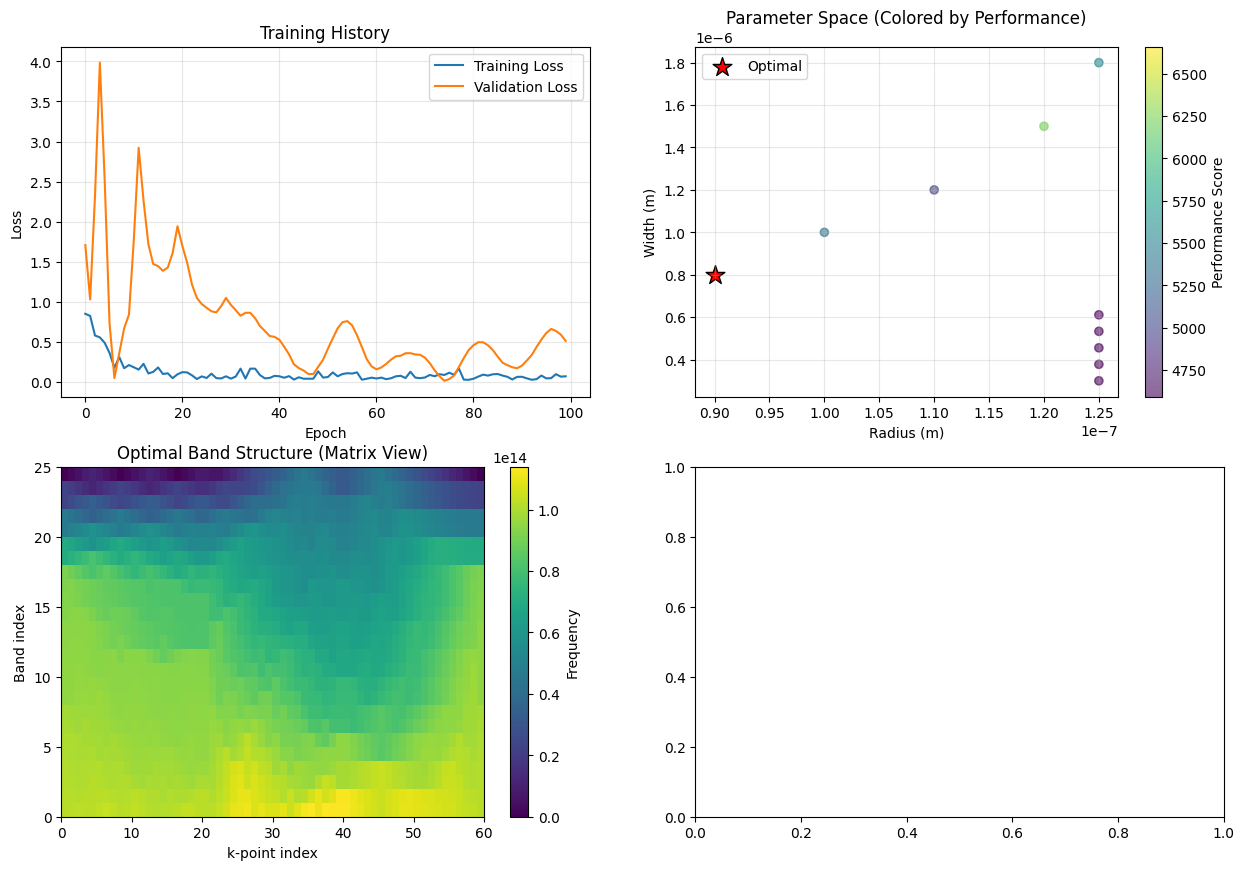

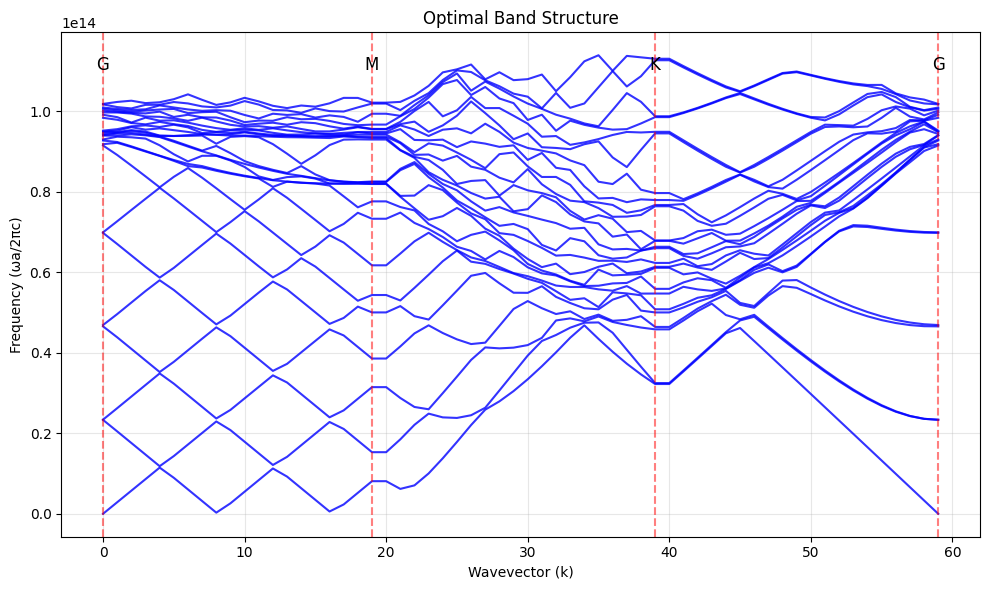


=== BAND STRUCTURE DIAGNOSTIC ===
Band structure shape: (25, 60)
Raw frequency range: 0.00e+00 to 1.14e+14 Hz
Manual normalized range: 0.000 to 0.190 a/λ
Band 0: 0.000 - 0.078 a/λ
Band 1: 0.020 - 0.082 a/λ
Band 2: 0.039 - 0.087 a/λ
Band 3: 0.059 - 0.094 a/λ

FINAL RESULTS:
Optimal Radius: 9.000e-08 m (90.0 nm)
Optimal Width:  8.000e-07 m (800.0 nm)
Performance Score: 6660.029
DEBUG - Normalized band range: 0.000 to 0.190 a/λ
DEBUG - Band 0: 0.000-0.078, Band 1: 0.020-0.082, Gap: -0.0583
DEBUG - Band 1: 0.020-0.082, Band 2: 0.039-0.087, Gap: -0.0426
DEBUG - Band 2: 0.039-0.087, Band 3: 0.059-0.094, Gap: -0.0283
DEBUG - Band 3: 0.059-0.094, Band 4: 0.078-0.100, Gap: -0.0161
DEBUG - Band 4: 0.078-0.100, Band 5: 0.085-0.119, Gap: -0.0150
DEBUG - Band 5: 0.085-0.119, Band 6: 0.091-0.135, Gap: -0.0278
DEBUG - Band 6: 0.091-0.135, Band 7: 0.093-0.153, Gap: -0.0419
DEBUG - Band 7: 0.093-0.153, Band 8: 0.095-0.154, Gap: -0.0577
DEBUG - Band 8: 0.095-0.154, Band 9: 0.099-0.155, Gap: -0.0544
DEB

In [ ]:

if __name__ == "__main__":
    run_complete_pwe_pipeline()